In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Dense, concatenate
from keras.utils import to_categorical

In [2]:
def load_and_preprocess_data(target_size, batch_size):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
        shear_range=0.2,  # Augmentation parameters
        zoom_range=0.2,
        horizontal_flip=True,
    )

    train_generator = datagen.flow_from_directory(
        'D:\\SEM-5\\ML-LAB\\chest_xray\\train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',

    )

    val_generator = datagen.flow_from_directory(
        'D:\\SEM-5\\ML-LAB\\chest_xray\\val',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',

    )
    test_set=datagen.flow_from_directory('D:\\SEM-5\\ML-LAB\\chest_xray\\test',
                                                 target_size = target_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')
    return train_generator, val_generator,test_set


In [3]:
target_size = (224,224)
batch_size = 32
n_classes = 2

train_set,val_set,test_set=load_and_preprocess_data(target_size,batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
def load_models():
  mlist=[]
  m1=load_model("D:\\SEM-5\\ML-LAB\\ML_PROJ\\VGGmodel.h5")
  mlist.append(m1)
  m2=load_model("C:\\Users\\MAAL SUBIKSHA\\Downloads\\INCEPTION_model.h5")
  mlist.append(m2)
  return mlist

In [5]:
models=load_models()

In [6]:
models

In [7]:
def define_stacked_model(members, n_classes):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

    ensemble_visible = [model.input for model in members]
    print(ensemble_visible)
    ensemble_outputs = [model.output for model in members]
    print(ensemble_outputs)
    merge = concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(n_classes, activation='sigmoid')(hidden)  # Use n_classes
    model = Model(inputs=ensemble_visible, outputs=output)
   # plot_model(model, show_shapes=True, to_file='model_graph.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [8]:
meta_model=define_stacked_model(models,2)

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'ensemble_1_input_1')>, <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'ensemble_2_input_1')>]
[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'ensemble_1_sequential')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'ensemble_2_dense_11')>]


In [9]:
meta_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ensemble_2_input_1 (InputLayer  [(None, 224, 224, 3  0          []                               
 )                              )]                                                                
                                                                                                  
 ensemble_2_conv2d (Conv2D)     (None, 111, 111, 32  864         ['ensemble_2_input_1[0][0]']     
                                )                                                                 
                                                                                                  
 ensemble_2_batch_normalization  (None, 111, 111, 32  96         ['ensemble_2_conv2d[0][0]']      
  (BatchNormalization)          )                                                             

In [10]:
def fit_stacked_model(model, train_generator, val_generator):
    # Preload data from the generators into NumPy arrays
  train_X = []
  train_y = []
  val_X = []
  val_y = []

# Load data from train generator
  for i in range(len(train_generator)):
    batch_X, batch_y = train_generator[i]
    train_X.append(batch_X)
    train_y.append(batch_y)

# Load data from validation generator
  for i in range(len(val_generator)):
    batch_X, batch_y = val_generator[i]
    val_X.append(batch_X)
    val_y.append(batch_y)

# Stack arrays to create full datasets
  train_X = np.vstack(train_X)
  train_y = np.vstack(train_y)
  val_X = np.vstack(val_X)
  val_y = np.vstack(val_y)

# Fit the stacked model using the preloaded data
  return train_X,train_y,val_X,val_y



In [11]:
train_X,train_y,val_X,val_y=fit_stacked_model(meta_model, train_set, val_set)

In [16]:
meta_model.fit([train_X,train_X], train_y, epochs=10, verbose=1)

Epoch 1/10
163/163 [==============================] - 873s 5s/step - loss: 0.1689 - accuracy: 0.9563
Epoch 2/10
163/163 [==============================] - 809s 5s/step - loss: 0.1404 - accuracy: 0.9578
Epoch 3/10
163/163 [==============================] - 813s 5s/step - loss: 0.1263 - accuracy: 0.9594
Epoch 4/10
163/163 [==============================] - 794s 5s/step - loss: 0.1198 - accuracy: 0.9624
Epoch 5/10
163/163 [==============================] - 789s 5s/step - loss: 0.1176 - accuracy: 0.9611
Epoch 6/10
163/163 [==============================] - 811s 5s/step - loss: 0.1164 - accuracy: 0.9601
Epoch 7/10
163/163 [==============================] - 791s 5s/step - loss: 0.1162 - accuracy: 0.9617
Epoch 8/10
163/163 [==============================] - 801s 5s/step - loss: 0.1167 - accuracy: 0.9618
Epoch 9/10
163/163 [==============================] - 1070s 7s/step - loss: 0.1172 - accuracy: 0.9611
Epoch 10/10
163/163 [==============================] - 1385s 8s/step - loss: 0.1150 - accu

In [14]:
meta_model.input

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'ensemble_1_input_1')>,
 <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'ensemble_2_input_1')>]

In [17]:

evaluation = meta_model.evaluate([val_X,val_X],val_y)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])


1/1 [==============================] - 8s 8s/step - loss: 0.8119 - accuracy: 0.6875
Validation Loss: 0.8118694424629211
Validation Accuracy: 0.6875


In [38]:
test_X=[]
test_y=[]
for i in range(len(test_set)):
    batch_X, batch_y = test_set[i]
    if(len(batch_X)==32):
        test_X.append(batch_X)
        test_y.append(batch_y)

In [39]:
len(test_y)

19

In [27]:
testnewX=test_X[:-1]

In [34]:
len(testnewX)

19

In [71]:
# Assuming you have new data as X_new
predictions = meta_model.predict([test_X[0],test_X[0]])

1/1 [==============================] - 9s 9s/step


In [72]:
predictions

array([[0.76023793, 0.24716225],
       [0.03430003, 0.9652081 ],
       [0.00937473, 0.9905224 ],
       [0.01850614, 0.981541  ],
       [0.0081397 , 0.99180114],
       [0.00636802, 0.99354595],
       [0.55143577, 0.4590253 ],
       [0.01805954, 0.9817318 ],
       [0.9230733 , 0.07577634],
       [0.00629646, 0.99362004],
       [0.00723682, 0.992635  ],
       [0.00674681, 0.9931709 ],
       [0.01356865, 0.98613334],
       [0.00657353, 0.99333984],
       [0.90199953, 0.08508143],
       [0.0093758 , 0.99054277],
       [0.9554751 , 0.0458947 ],
       [0.00668355, 0.993272  ],
       [0.02424842, 0.9750348 ],
       [0.6480569 , 0.36611465],
       [0.08028473, 0.9167432 ],
       [0.00623617, 0.99368334],
       [0.01529197, 0.9841395 ],
       [0.00623633, 0.9936833 ],
       [0.01077115, 0.98893225],
       [0.0062844 , 0.9936375 ],
       [0.9708678 , 0.03177571],
       [0.84632194, 0.16615252],
       [0.836414  , 0.17858565],
       [0.9267217 , 0.06914702],
       [0.

In [75]:
test_y[0]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [42]:
test_X[0][0].shape

(224, 224, 3)

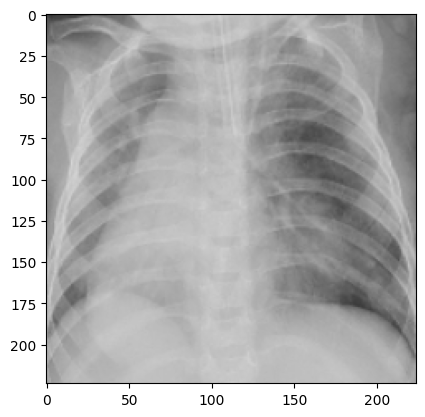

In [56]:
import matplotlib.pyplot as plt
plt.imshow(test_X[1][1])

In [57]:
test_y[1][1]

array([0., 1.], dtype=float32)

In [58]:
single_test_data_point=test_X[1][1]
single_test_data_point = single_test_data_point.reshape(1, 224, 224, 3)

In [59]:
predictions = meta_model.predict([single_test_data_point,single_test_data_point])

1/1 [==============================] - 0s 377ms/step


In [60]:
predictions

array([[0.00631497, 0.9936023 ]], dtype=float32)

In [50]:
meta_model.save("ensembled.h5")

In [69]:
from keras.utils import plot_model
plot_model(meta_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


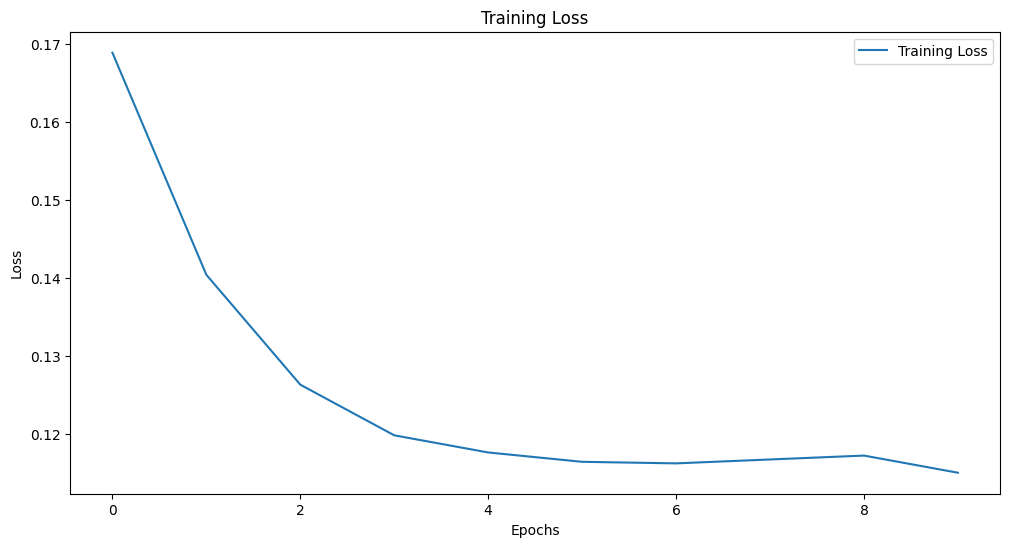

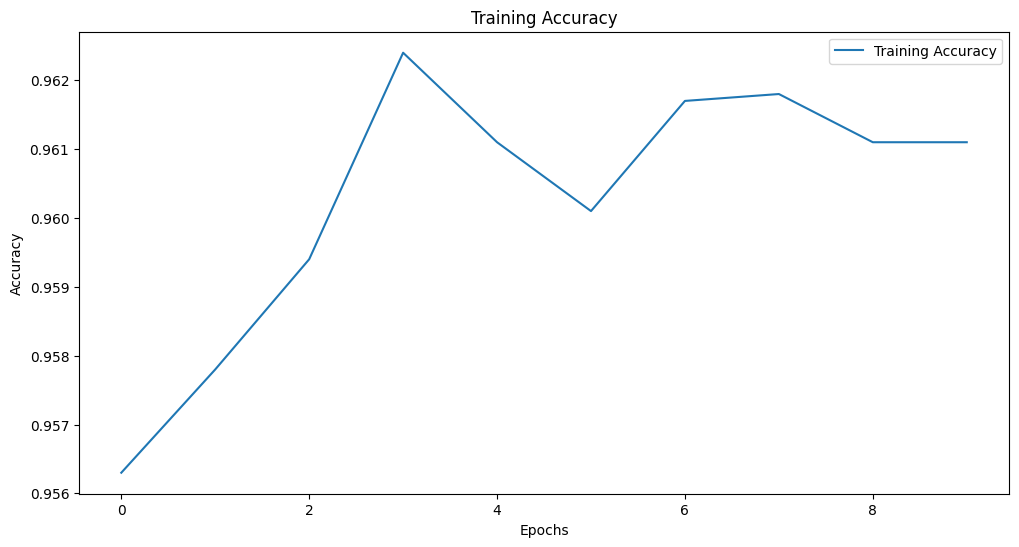

In [83]:
training_loss = [0.1689,0.1404,0.1263,0.1198,0.1176,0.1164,0.1162,0.1167,0.1172,0.1150]
training_accuracy =[0.9563,0.9578,0.9594,0.9624,0.9611,0.9601,0.9617,0.9618,0.9611,0.9611]


# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(training_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()